### Se deseja saber mais sobre esse projeto para além do código, recomendo a leitura do arquivo README, disponível no repositório deste projeto no Github.

In [1]:
# Pacotes essenciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set_style('darkgrid')

np.set_printoptions(suppress=True)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Preprocessamento
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# Metricas para avaliação
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score

# Modelos e CV

from pycaret.regression import setup, compare_models

from catboost import CatBoostRegressor
from sklearn.linear_model import BayesianRidge

In [2]:
# Retirando FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# lendo os arquivos com os dados de treino e de teste

train0 = pd.read_csv('C:/Users/Victor/Desktop/Estudos_Data/Kaggle/HousePricePrediction/dados/train.csv')
test0 = pd.read_csv('C:/Users/Victor/Desktop/Estudos_Data/Kaggle/HousePricePrediction/dados/test.csv')

In [4]:
# Vamos salvar a variavel alvo do Dataset de treino na variavel "target" e os Ids do Dataset de teste na variavel test_ids
# Essas informações serão usadas posteriormente, mas não serão úteis agora na hora da limpeza.

target = train0.SalePrice
test_ids = test0.Id

In [5]:
train1 = train0.drop(columns=['Id', 'SalePrice'])
test1 = train0.drop(columns=['Id'])

In [6]:
train1

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,NaN,Attchd,1950.0,Unf,1,240,TA,TA,Y,366,0,112,0,0,0,NaN,N

Uma estratégia para aumentar a precisão do modelo que geraremos ao final desse notebook é concatenar os datasets de treino e de teste, para que tenhamos mais informação na hora de fazer o tratamento dos dados. Embora essa estratégia seja muitas vezes utilizadas em competições para aumentar o score do modelo, ela é de um tipo de data leakage (vazamento de dados), já que os dados de teste estão influenciando o pré-processamento e, como consequência, o resultado do modelo. Esse tipo de estratégia não pode ser utilizada em um ambiente de produção ou em um projeto real já que gera um viés no modelo, algo que queremos evitar ao máximo. Portanto, optei por manter o dataset de teste intocado, por enquanto. Ele será utilizado exclusivamente para realizar as previsões, como em um ambiente de produção real. Mesmo que essa decisão provavelmente reduza o score do nosso modelo, esse score será mais realista.

Um outro motivo pelo qual algumas pessoas concatenam os datasets de treino e teste é para que não tenham que fazer a transformação duas vezes ou desenvolver uma função que efetue o pré-processamento. Todavia, como já explicado, não vamos fazer isso, e teremos que desenvolver uma função de pré-processamento, que será explicada no momento oportuno.

## Limpeza de dados

### assegurando os tipos de dados (data types)

Uma prática que ajuda a manter as etapas do processo em ordem é criar copias do dataframe a medida que vamos transformando-o. Em caso de problemas, podemos voltar a última copia, facilitando o debugging.

A primeira coisa que vamos fazer é assegurar que as variáveis categóricas estão representadas por strings (texto) e que as variáveis numéricas estão representadas por números.

In [7]:
# criando uma cópia
train2 = train1.copy()

In [8]:
train2.select_dtypes(np.number)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,1999,2000,0.0,0,0,953,953,953,694,0,1647,0,0,2,1,3,1,7,1,1999.0,2,460,0,40,0,0,0,0,0,8,2007
1456,20,85.0,13175,6,6,1978,1988,119.0,790,163,589,1542,2073,0,0,2073,1,0,2,0,3,1,7,2,1978.0,2,500,349,0,0,0,0,0,0,2,2010
1457,70,66.0,9042,7,9,1941,2006,0.0,275,0,877,1152,1188,1152,0,2340,0,0,2,0,4,1,9,2,1941.0,1,252,0,60,0,0,0,0,2500,5,2010
1458,20,68.0,9717,5,6,1950,1996,0.0,49,1029,0,1078,1078,0,0,1078,1,0,1,0,2,1,5,0,1950.0,1,240,366,0,112,0,0,0,0,4,2010


In [9]:
# Há apenas uma variável categórica sendo representada como numérica. A variável MSSubClass. Temos que transformá-la.

train2.MSSubClass = train2.MSSubClass.astype(str)

In [10]:
# Não há variáveis numéricas representadas como variáveis categóricas. 

train2.select_dtypes('object').head()

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,60,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,20,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,60,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,70,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,60,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


## Imputação (Imputation)

### Imputação de valores categóricos

A imputação de valores é um momento delicado e que precisa ser bem executado, ou o modelo pode ficar totalmente comprometido. Vamos começar imputando os valores categóricos. 
Nesse dataset, o valor ausente nem sempre representa falta de informação, como pode ser visto no dicionário de dados disponibilizado no desafio do Kaggle. Por exemplo: Nas variáveis relativas ao porão, o valor NaN representa que a casa não tem porão. O mesmo ocorre com a variável PoolQC, cujo valor NaN representa que a casa não tem piscina. 
Portanto, a estratégia que vamos adotar será a seguinte: Quando a informação ausente representar alguma informação (descrita no dicionário de dados), vamos substituir o valor NaN pela palavra "None". Quando o valor NaN de fato representar um valor ausente, vamos substituí-lo pela moda da coluna. 

In [11]:
# Imputação de um valor que representa informação. Vamos utilizar a palavra "None"

for column in ['Alley', 
               'BsmtQual', 
               'BsmtCond', 
               'BsmtExposure', 
               'BsmtFinType1', 
               'BsmtFinType2', 
               'FireplaceQu', 
               'GarageType', 
               'GarageFinish', 
               'GarageQual', 
               'GarageCond',
               'PoolQC', 
               'Fence',
               'MiscFeature']:
    train2[column] = train2[column].fillna('None')

# Imputação com a moda da coluna

for column in ['MSZoning',
                'Utilities',
                'Exterior1st',
                'Exterior2nd',
                'MasVnrType',
                'Electrical',
                'KitchenQual',
                'Functional',
                'SaleType']:
    train2[column] = train2[column].fillna(train2[column].mode()[0])

In [12]:
# vamos verificar se a imputação das variáveis categóricas foi feita corretamente

train2.select_dtypes('object').isna().sum().sum()

0

### Imputação de valores numéricos

In [13]:
train3 = train2.copy()
numeric_df = train3.select_dtypes(np.number)

In [14]:
numeric_df.isna().sum()

LotFrontage      259
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         8
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       81
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
dtype: int64

Agora, precisamos imputar os valores ausentes nas colunas numéricas. Há várias maneiras de fazer isso. Nessa ocasião, utilizaremos a mais simples: usando a média dos valores das colunas numéricas do dataset de treino. Em futuras versões do projeto podemos testar imputações mais sofisticadas.

In [15]:
simple_imputer = SimpleImputer(strategy='mean')

In [16]:
simple_imputer.fit(numeric_df)

SimpleImputer()

In [17]:
numeric_df_transformed = simple_imputer.transform(numeric_df)
numeric_df_transformed = pd.DataFrame(numeric_df_transformed, columns=numeric_df.columns)

In [18]:
numeric_df_transformed

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,150.0,856.0,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,8.0,0.0,2003.0,2.0,548.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0
1,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,284.0,1262.0,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,6.0,1.0,1976.0,2.0,460.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0
2,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,434.0,920.0,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,6.0,1.0,2001.0,2.0,608.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0
3,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,540.0,756.0,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,7.0,1.0,1998.0,3.0,642.0,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0
4,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,490.0,1145.0,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,9.0,1.0,2000.0,3.0,836.0,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,62.0,7917.0,6.0,5.0,1999.0,2000.0,0.0,0.0,0.0,953.0,953.0,953.0,694.0,0.0,1647.0,0.0,0.0,2.0,1.0,3.0,1.0,7.0,1.0,1999.0,2.0,460.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,8.0,2007.0
1456,85.0,13175.0,6.0,6.0,1978.0,1988.0,119.0,790.0,163.0,589.0,1542.0,2073.0,0.0,0.0,2073.0,1.0,0.0,2.0,0.0,3.0,1.0,7.0,2.0,1978.0,2.0,500.0,349.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2010.0
1457,66.0,9042.0,7.0,9.0,1941.0,2006.0,0.0,275.0,0.0,877.0,1152.0,1188.0,1152.0,0.0,2340.0,0.0,0.0,2.0,0.0,4.0,1.0,9.0,2.0,1941.0,1.0,252.0,0.0,60.0,0.0,0.0,0.0,0.0,2500.0,5.0,2010.0
1458,68.0,9717.0,5.0,6.0,1950.0,1996.0,0.0,49.0,1029.0,0.0,1078.0,1078.0,0.0,0.0,1078.0,1.0,0.0,1.0,0.0,2.0,1.0,5.0,0.0,1950.0,1.0,240.0,366.0,0.0,112.0,0.0,0.0,0.0,0.0,4.0,2010.0


In [19]:
train3_cat_transformed = train3.select_dtypes('object')
train3 = pd.concat([numeric_df_transformed, train3_cat_transformed], axis=1)

In [20]:
# verificando se as transformações geraram o resultado esperado.

train3.isna().sum().sum()

0

### Feature Transformation

In [21]:
train4 = train3.copy()

Os diferentes algoritmos de Machine Learning fazem diferentes suposições sobre os dados. Se essas suposições forem violadas, o resultado do algoritmo não será confiável e sua performance será ruim. Uma suposição compartilhada por diversos algoritmos é a de que as variáveis preditoras são normalmente distribuídas (seguem uma distribuição normal, também chamada de gaussiana).
Uma boa maneira de testar se uma distribuição é gaussiana é utilizando estatística, através do teste Shapiro-Wilk. Todavia, esse teste também tem suas próprias suposições, e é inviável testar cada uma dessas suposições para as mais de trinta variáveis do dataset. Por esse motivo, adotaremos uma ideia não técnica para descobrir quais colunas estão mais distantes de uma distribuição normal e que vamos escolher transformar: utilizaremos a função skew do módulo stats, da famosa biblioteca scipy. Uma distribuição normal perfeita (o nosso mundo ideial) existe quando o resultado dessa função é igual a 0. Portanto, vamos escolher transformar a coluna o resultado absoluto desse teste for maior do que 0.5. Caso contrário, manteremos a coluna como está.

A escolha do valor 0.5 não segue nenhum parâmetro matemático. Aqui, cabe um pouco da inventividade e experência do cientista de dados aliada com o processo de tentativa e erro na busca pelo melhor modelo. Não há problema algum em tomar decisões como essa em projetos reais, contanto que essas decisões sejam documentadas e justificadas.

In [22]:
skew_df = pd.DataFrame(train4.select_dtypes(np.number).columns, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda x: stats.skew(train4[x]))
skew_df['Absolute_Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Absolute_Skew'] >= 0.5

In [23]:
skew_df

,Feature,Skew,Absolute_Skew,Skewed
0,LotFrontage,2.382499,2.382499,True
1,LotArea,12.195142,12.195142,True
2,OverallQual,0.216721,0.216721,False
3,OverallCond,0.692355,0.692355,True
4,YearBuilt,-0.612831,0.612831,True
5,YearRemodAdd,-0.503044,0.503044,True
6,MasVnrArea,2.673661,2.673661,True
7,BsmtFinSF1,1.683771,1.683771,True
8,BsmtFinSF2,4.250888,4.250888,True
9,BsmtUnfSF,0.919323,0.919323,True


Já selecionamos as colunas em que vamos aplicar a transformação, cabe agora discutir qual transformação será aplicada. A transformação mais simples para aproximar nossos dados de uma distribuição normal é a transformação logarítmica. Mesmo sendo simples, essa transformação é incrivelmente poderosa e cumpre muito bem a sua função.

Neste caso utilizaremos um método que calcula o log do valor + 1. A razão disso é para que valores iguais a zero não causem um erro, já que o resultado do log(0) é uma indefinição matemática. Acredito que uma explicação matemática mais profunda seja irrelevante neste momento, portanto, permita-me dispensá-la.

In [24]:
for column in skew_df.query('Skewed == True')['Feature'].values:
    train4[column] = np.log1p(train4[column])

In [25]:
train4.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,4.189655,9.042040,7.0,1.791759,7.602900,7.602900,5.283204,6.561031,0.0,5.017280,6.753438,6.753438,6.751101,0.0,7.444833,0.693147,0.000000,2.0,0.693147,3.0,0.693147,2.197225,0.000000,7.602900,2.0,548.0,0.000000,4.127134,0.000000,0.0,0.0,0.0,0.0,2.0,2008.0,60,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,None,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
1,4.394449,9.169623,6.0,2.197225,7.589336,7.589336,0.000000,6.886532,0.0,5.652489,7.141245,7.141245,0.000000,0.0,7.141245,0.000000,0.693147,2.0,0.000000,3.0,0.693147,1.945910,0.693147,7.589336,2.0,460.0,5.700444,0.000000,0.000000,0.0,0.0,0.0,0.0,5.0,2007.0,20,RL,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
2,4.234107,9.328212,7.0,1.791759,7.601902,7.602401,5.093750,6.188264,0.0,6.075346,6.825460,6.825460,6.765039,0.0,7.488294,0.693147,0.000000,2.0,0.693147,3.0,0.693147,1.945910,0.693147,7.601902,2.0,608.0,0.000000,3.761200,0.000000,0.0,0.0,0.0,0.0,9.0,2008.0,60,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
3,4.110874,9.164401,7.0,1.791759,7.557995,7.586296,0.000000,5.379897,0.0,6.293419,6.629363,6.869014,6.629363,0.0,7.448916,0.693147,0.000000,1.0,0.000000,3.0,0.693147,2.079442,0.693147,7.600402,3.0,642.0,0.000000,3.583519,5.609472,0.0,0.0,0.0,0.0,2.0,2006.0,70,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,None,None,None,WD,Abnorml
4,4.442651,9.565284,8.0,1.791759,7.601402,7.601402,5.860786,6.486161,0.0,6.196444,7.044033,7.044033,6.960348,0.0,7.695758,0.693147,0.000000,2.0,0.693147,4.0,0.693147,2.302585,0.693147,7.601402,3.0,836.0,5.262690,4.442651,0.000000,0.0,0.0,0.0,0.0,12.0,2008.0,60,RL,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal


### Scaling das variáveis numericas + Encoding das variáveis categóricas

Vamos aplicar duas transformações agora. A primeira delas será o Scaling, feito exclusivamente nas variáveis numéricas, e depois aplicaremos o Encoding, feito exclusivamente nas variáveis categóricas. Para evitar uma repetição de código desnecessária vamos separar as variáveis nesses dois grupos, transformá-las e depois juntá-las novamente.

In [26]:
train5 = train4.copy()

In [27]:
train5_num = train5.select_dtypes(np.number).copy()

Um algoritmo nada mais é do que uma sequência de procedimentos matemáticos. Portanto, se utilizássemos um modelo que pressupõe que os dados estão na mesma escala e essa suposição não fosse atendida,  o modelo iria atribuir mais importância às variáveis que estão em uma escala maior. Tomemos um exemplo: Um algoritmo poderia atribuir maior importância, por exemplo, a uma variável "salário", que seria medida em milhares de reais, do que a uma variável "idade", que seria medida na casa das dezenas, ainda que a variável idade fosse, nesse caso hipotético, mais relevante para prever uma determinada variável alvo, como se um cliente vai ou não pagar um empréstimo. O resultado seria evidentemente um modelo terrível. Por isso, pôr as variáveis na mesma escala é quase sempre uma etapa essencial do pré-processamento.

In [28]:
# aplicando o Scaling (padronização)

scaler = StandardScaler()
scaler.fit(train5_num)

train5_num = pd.DataFrame(scaler.transform(train5_num), columns=train5_num.columns)

In [29]:
# verificando se a transformação foi feita corretamente

train5_num.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,-0.087206,-0.133270,0.651479,-0.460408,1.045180,0.877541,1.193074,0.779431,-0.355342,-0.340511,0.002513,-0.803645,1.180528,-0.133602,0.529194,1.148788,-0.242923,0.789741,1.258580,0.163779,-0.207607,0.946985,-1.013562,1.016709,0.311725,0.351000,-0.946701,0.845209,-0.404244,-0.128521,-0.292769,-0.069393,-0.190481,-1.599111,0.138777
1,0.563711,0.113413,-0.071836,1.948163,0.163445,-0.424186,-0.815959,0.888257,-0.355342,0.002218,0.341114,0.418479,-0.870117,-0.133602,-0.381965,-0.833225,4.021453,0.789741,-0.769639,0.163779,-0.207607,-0.226437,0.743356,-0.098044,0.311725,-0.060731,1.249540,-1.072916,-0.404244,-0.128521,-0.292769,-0.069393,-0.190481,-0.489110,-0.614439
2,0.054079,0.420049,0.651479,-0.460408,0.980275,0.829642,1.121030,0.654803,-0.355342,0.230372,0.065397,-0.576677,1.184762,-0.133602,0.659631,1.148788,-0.242923,0.789741,1.258580,0.163779,-0.207607,-0.226437,0.743356,0.934651,0.311725,0.631726,-0.946701,0.675137,-0.404244,-0.128521,-0.292769,-0.069393,-0.190481,0.990891,0.138777
3,-0.337602,0.103317,0.651479,-0.460408,-1.873790,-0.715872,-0.815959,0.384539,-0.355342,0.348034,-0.105819,-0.439421,1.143550,-0.133602,0.541448,1.148788,-0.242923,-1.026041,-0.769639,0.163779,-0.207607,0.397039,0.743356,0.811411,1.650307,0.790804,-0.946701,0.592558,2.844374,-0.128521,-0.292769,-0.069393,-0.190481,-1.599111,-1.367655
4,0.716916,0.878431,1.374795,-0.460408,0.947798,0.733773,1.412710,0.754400,-0.355342,0.295711,0.256237,0.112127,1.244087,-0.133602,1.282295,1.148788,-0.242923,0.789741,1.258580,1.390023,-0.207607,1.438928,0.743356,0.893592,1.650307,1.698485,1.080884,0.991848,-0.404244,-0.128521,-0.292769,-0.069393,-0.190481,2.100892,0.138777


### Encoding de variáveis categóricas

Agora vamos aplicar uma transformação essencial para variáveis categóricas. Como explicado anteriormente, um algoritmo é uma sequência de passos matemáticos, e modelos matemáticos não entendem palavras. Por esse motivo, precisamos transformar as categorias (palavras) em algo que o modelo entenda (números). Vamos codificar nossas variáveis usando o OneHotEncoding. Esse tipo de transformação é mais adequado quando as categorias NÃO apresentam uma ordem natural/sequencial. Escolaridade, por exemplo, é uma categoria sequencial: há o ensino básico, depois o ensino fundamental, então o ensino médio, e assim por diante. Já o estado civil não é sequencial, já que não há uma ordem lógica entre solteiro, casado, divorciado, etc.

Há no dataset variáveis categóricas que são sequenciais, como aquelas envolvendo "qualidade" e "condição". Todavia, para fins de simplicidade na construção desse primeiro modelo que servirá como linha de base para modelos futuros, vamos codificar todas as variáveis catégoricas com o OneHotEncoder.

In [30]:
OneHot = OneHotEncoder(categories='auto', handle_unknown = 'ignore')
OneHotTransformed = OneHot.fit_transform(train5[list(train5.select_dtypes('object').columns)])
cat_vars_encoded = pd.DataFrame(OneHotTransformed.toarray())
cat_vars_encoded.columns = OneHot.get_feature_names_out()

In [31]:
# vamos concatenar o dataset com as variáveis numéricas transformadas com o dataset com as variáveis categóricas transformadas

train_final = pd.concat([train5_num, cat_vars_encoded], axis=1)

In [32]:
train_final

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,Fir

### Transformação da variável alvo

Assim como ocorre com as variáveis preditoras, muitos algoritmos performam melhor caso a variável alvo (aquele valor cujo nosso modelo tenta prever) também siga uma distribuição normal. Por esse motivo, vamos fazer uma transformação logarítmica com a variável alvo. Mais do que isso, vamos plotar um pequeno gráfico que deixará bem mais claro como funciona a transformação logarítmica.

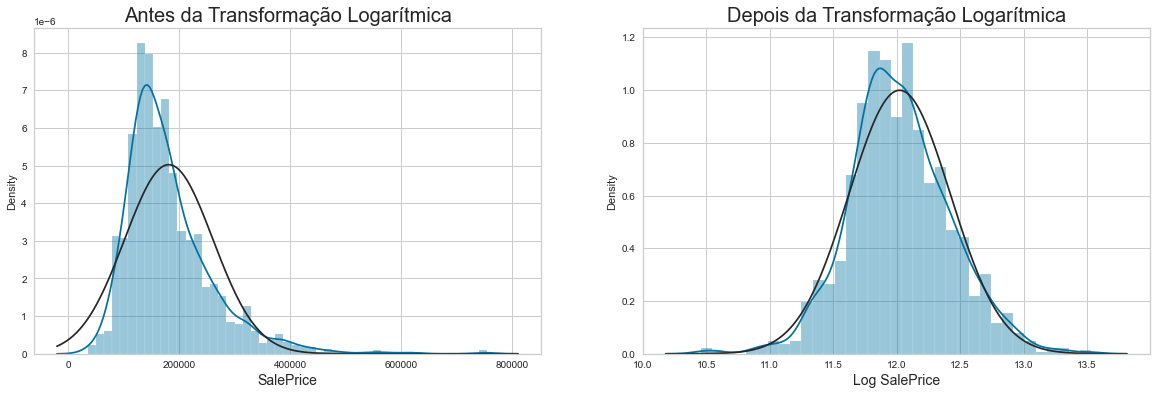

In [60]:
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
sns.distplot(target, kde=True, fit=stats.norm)
plt.title('Antes da Transformação Logarítmica', size=20)
plt.xlabel("SalePrice", size=14)

plt.subplot(1,2,2)
sns.distplot(np.log(target), kde=True, fit=stats.norm)
plt.xlabel("Log SalePrice", size=14)

plt.title('Depois da Transformação Logarítmica', size=20)
plt.show()

No subplot à esquerda podemos ver a distribuição do preço das casas antes da transformação. Em termos simples, a curva azul representa a distribuição dos nossos dados, e podemos notar uma "cauda" ou "rabo" (tail). Em inglês, chamamos essa distribuição com uma cauda para a direita de "right skewed distribution". Enquanto isso, a linha preta mostra como a linha azul DEVERIA SER caso esses dados estivessem normalmente distribuidos. De imediato, notamos que essas linhas estão bem diferentes uma da outra.

Já no gráfico à direita podemos ver como a distribuição dos dados ficou após a transformação. Ainda que a linha azul não esteja perfeitamente alinhada com a linha preta, a melhora é evidente. O que a transformação logarítmica fez foi _transformar o dado sem alterar a informação contida nele_.

Como resultado, nossos modelos que pressupõe que a variável alvo segue uma distribuição normal terão resultados muito melhores, enquanto modelos que não fazem essa pressuposição continuarão a performar normalmente.

In [34]:
# vamos criar uma variável com a transformação logaritmica aplicada na variável SalePrice

log_target = np.log(target)

Terminamos todas as transformações necessárias no dataframe de treino, porém nosso dataset de teste ainda está intacto (já que no início do projeto optamos por não concatenar treino e teste, para não ocorrer o data leakage). Isso significa que teremos que fazer no dataset de teste exatamente as mesmas transformações que fizemos no dataset de treino, caso contrário, nosso modelo não vai ser capaz de fazer boas previsões. Além do mais, o dataset de teste tem valores ausentes em colunas que o dataset de treino estava completo. Para resolver todos esses problemas vamos criar uma função que vai fazer todo o pré-processamento de uma única vez.

In [35]:
def PreprocessData(dataframe):
    
    df1 = dataframe.copy()
    
    df1 = dataframe.drop(columns=['Id'])
    df1.MSSubClass = df1.MSSubClass.astype(str)
    
    # imputação de valores categóricos por um valor fixo (None)
    for column in ['Alley', 
               'BsmtQual', 
               'BsmtCond', 
               'BsmtExposure', 
               'BsmtFinType1', 
               'BsmtFinType2', 
               'FireplaceQu', 
               'GarageType', 
               'GarageFinish', 
               'GarageQual', 
               'GarageCond',
               'PoolQC', 
               'Fence',
               'MiscFeature']:
        df1[column] = df1[column].fillna('None')

    # Imputação de valores categóricos com a moda da coluna:
    for column in ['MSZoning',
                'Utilities',
                'Exterior1st',
                'Exterior2nd',
                'MasVnrType',
                'Electrical',
                'KitchenQual',
                'Functional',
                'SaleType']:
        df1[column] = df1[column].fillna(df1[column].mode()[0])
        
    # imputação de valores numéricos usando o SimpleImputer já treinado
    
    num_column_names = df1.select_dtypes(np.number).columns
    prepdata_num = simple_imputer.transform(df1.select_dtypes(np.number))
    num_data_transformed1 = pd.DataFrame(prepdata_num, columns=num_column_names)
    df2 = pd.concat([num_data_transformed1, df1.select_dtypes('object')], axis=1)
    
    # Fazendo a transformação logaritmica nas mesmas colunas que fizemos essa transf. nos dados de treino
    
    for column in ['LotFrontage', 'LotArea', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 
                    'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
                    'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
                    'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']:
        df2[column] = np.log1p(df2[column])
        
    # Padronizando os dados numericos
        
    df2_num_cols = df2.select_dtypes(np.number)
    df2_num_cols_names = df2.select_dtypes(np.number).columns
    df2_num_cols_standardized = pd.DataFrame(scaler.transform(df2_num_cols), columns = df2_num_cols_names)
    
    # One Hot Encoding os dados cetegóricos
    
    df2_cat_cols = df2.select_dtypes('object')
    df2_cat_cols_OneHotEncoded = pd.DataFrame(OneHot.transform(df2_cat_cols).toarray())
    df2_cat_cols_OneHotEncoded.columns = OneHot.get_feature_names_out()
    
    df_final = pd.concat([df2_num_cols_standardized, df2_cat_cols_OneHotEncoded], axis=1)
    
    
    return df_final

A partir de agora, com a execução de uma simples função nós podemos fazer todas as etapas que escolhemos aplicar no pré-processamento dos dados de uma única vez. Isso é muito útil já que, caso fossemos receber mais dados sobre casas e precisássemos prever os seus preços, fariamos o pré-processamento de maneira praticamente instantânea.

In [36]:
# aplicando a função de pré-processamento nos nossos dados de teste

test_final = PreprocessData(test0)

In [37]:
test_final

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,Fir

Ufa! Terminamos toda a etapa de pré-processamento. Finalmente podemos partir para a mais divertida e de um projeto de Machine Learning: criar modelos e fazer previsões!

In [38]:
_ = setup(data=pd.concat([train_final, log_target], axis=1), target='SalePrice')

,Description,Value
0,Session id,7473
1,Target,SalePrice
2,Target type,Regression
3,Original data shape,"(1460, 317)"
4,Transformed data shape,"(1460, 317)"
5,Transformed train set shape,"(1021, 317)"
6,Transformed test set shape,"(439, 317)"
7,Numeric features,316
8,Preprocess,True
9,Imputation type,simple


In [58]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0799,0.0146,0.1184,0.9081,0.0092,0.0067,0.4550
gbr,Gradient Boosting Regressor,0.0890,0.0168,0.1270,0.8948,0.0098,0.0074,0.3920
br,Bayesian Ridge,0.0838,0.0176,0.1281,0.8870,0.0098,0.0070,0.3910
lightgbm,Light Gradient Boosting Machine,0.0916,0.0180,0.1314,0.8869,0.0102,0.0077,0.3880
ridge,Ridge Regression,0.0868,0.0191,0.1335,0.8776,0.0103,0.0073,0.3840
xgboost,Extreme Gradient Boosting,0.0969,0.0199,0.1391,0.8751,0.0107,0.0081,0.3960
et,Extra Trees Regressor,0.0980,0.0206,0.1419,0.8723,0.0110,0.0082,0.4020
rf,Random Forest Regressor,0.0975,0.0208,0.1418,0.8705,0.0110,0.0082,0.4020
omp,Orthogonal Matching Pursuit,0.0929,0.0224,0.1458,0.8597,0.0112,0.0078,0.3880
huber,Huber Regressor,0.0957,0.0233,0.1498,0.8530,0.0116,0.0080,0.3870


Utilizar o método compare_models da biblioteca Pycaret é extremamente útil para que, de forma rápida e simples, nosso código possa testar diversos algoritmos diferentes sobre o nosso conjunto de dados. Depois que o compare_models nos mostra os algoritmos com melhor performance podemos importá-los propriamente, testá-los e fazer a otimização de hiperparâmetros para que cheguemos no melhor resultado possível. 

Como esse método do pycaret utiliza validação cruzada (um importante conceito para que a avaliação do nosso modelo seja mais realista), o resultado das métricas nunca serão iguais (o algoritmo que ficou em terceiro lugar em uma passada pode ficar em primeiro na próxima etc). Por isso, é importante explorar mais a fundo os algoritmos que performaram melhor. Depois de rodar esse código algumas vezes durante a produção desse notebook notei que dois dos algoritmos que sempre apareciam entre as melhores performances foram o CatBoost Regressor e o Bayesian Ridge. 

Esse resultado é muito interessante, dado que os dois algoritmos divergem em quase todos os aspectos. O catboost é um algoritmo bastante sofisticado que alia as árvores de decisão com um método de otimização chamado Gradient Boosting. Já o Bayesian Ridge é um algoritmo muito mais simples, que utiliza a inferência bayesiana (uma decorrência imediata da fórmula de Bayes) e que, ainda que consiga reconhecer relações não lineares com a variável alvo, resulta uma relação linear das variáveis preditoras com a variável alvo. Ao final deste notebook explorarei um pouco mais sobre os resultados que obtivemos com esses dois algoritmos.

In [41]:
Baseline_catboost = CatBoostRegressor(verbose=0)

In [42]:
Baseline_catboost.fit(train_final, log_target)

In [43]:
predictionsCatboost = Baseline_catboost.predict(test_final)
predictionsCatboost = np.exp(predictionsCatboost)

In [44]:
predictionsCatboost

array([123981.21872193, 166949.54724659, 187398.85550038, ...,
       167508.67636791, 114202.75485796, 225359.23274104])

In [45]:
Baseline_BRidge = BayesianRidge()

In [46]:
Baseline_BRidge.fit(train_final, log_target)

BayesianRidge()

In [47]:
predictionsBRidge = Baseline_BRidge.predict(test_final)
predictionsBRidge = np.exp(predictionsBRidge)

In [48]:
predictionsBRidge

array([117332.65897344, 156246.59204488, 182877.66055357, ...,
       171898.88177179, 118068.28812591, 221185.31401457])

In [49]:
### OrthogonalMatchingPursuit

In [50]:
from sklearn.ensemble import GradientBoostingRegressor

In [51]:
Baseline_GradientBoosting = GradientBoostingRegressor()

In [52]:
Baseline_GradientBoosting.fit(train_final, log_target)

GradientBoostingRegressor()

In [53]:
predictionsGBR = Baseline_GradientBoosting.predict(test_final)
predictionsGBR = np.exp(predictionsGBR)

In [54]:
predictionsGBR

array([122605.92312088, 153748.85817563, 184529.59263845, ...,
       153626.99315971, 117851.25790522, 237814.98045166])

### Submeter resultados

Para submeter os resultados precisamos salvar o arquivo em formato CSV e submeter para a competição. O código que cria o arquivo está comentado para evitar que ele seja sobreescrito toda vez que o código for rodado. Apenas para fins ilustrativos, a última célula do arquivo cria um dataframe com as previsões que resultaram dos dois algoritmos que (nessa primeira versão do projeto) obtiveram os melhores resultados.

In [55]:
Predictions_df = pd.DataFrame({'Id':test_ids, 'SalePrice':predictionsGBR})

In [56]:
#Predictions_df.to_csv('GradientBoostingRegressor_V1.csv', index=False, header=True)

In [57]:
predictions_full_df = pd.DataFrame({'Id':test_ids, 'BayesianRidge_V1':predictionsBRidge, 'CatBoost_V1':predictionsCatboost})
predictions_full_df

,Id,BayesianRidge_V1,CatBoost_V1
0,1461,117332.658973,123981.218722
1,1462,156246.592045,166949.547247
2,1463,182877.660554,187398.855500
3,1464,197165.744030,194429.709055
4,1465,200475.229465,185901.252465
...,...,...,...
1454,2915,86764.307192,79919.108131
1455,2916,81258.832701,82283.675474
1456,2917,171898.881772,167508.676368
1457,2918,118068.288126,114202.754858


Esse último dataframe nos mostra as cinco primeiras e cinco últimas previsões dos dois algoritmos: CatBoostRegressor e Bayesian Ridge. Com esses poucos exemplos podemos notar que as previsões dos dois modelos geralmente estão distantes algumas casas de milhar umas das outras, o que é esperado dado o erro do modelo. E já que falamos em erro, vamos observar brevemente os resultados alcançados:

O score do modelo BayesianRidge_V1 foi de 0.12365
O score do modelo CatBoost_V1 foi de 0.12681

Todavia, esse número não parece dizer muita coisa para um ser humano, já que não é intuitivo para a mente humana interpretar o logarítmo dos resultados. Por esse motivo, há uma outra competição do Kaggle com os mesmos dados e o mesmo objetivo, que nos traz o resultado sem a aplicação do log dos valores. Neste caso:

O erro médio do modelo BayesianRidge_V1 foi de 14065 dólares
O erro médio do modelo CatBoost_V1 foi de 13799 dólares. 

Ou seja, nossos modelos erram o preço de uma casa em aproximadamente 14 mil dólares (para mais ou para menos), um resultado que considero muito bom, ainda que exista um pequeno espaço para melhoramentos (os melhores modelos legítimos para essa competição apresentam um erro de 11600 dólares).

Por último, os leitores atentos podem estar se perguntando porque o modelo Bayesian Ridge apresentou um resultado melhor na primeira métrica (e, de fato, o modelo BayesianRidge_V1 é melhor do que o modelo CatBoost_V1) se o seu erro médio foi 200 dólares maior. Isso acontece porque nesse caso o log dos valores é mais adequado para se utilizar como métrica, pois ele faz com que o erro das previsões de casas caras e de casas baratas tenham um impacto igual na avaliação. Tomemos um último exemplo:

Qual situação é pior: que o nosso modelo preveja o preço de 180.000 dólares para uma casa que custa 200.000 dólares ou que ele preveja o preço de 780.000 dólares para uma casa que custa 800.000 dólares? A primeira situação é pior, porque ele errou em 10% o valor da casa, enquanto na segunda ele errou apenas 2.5%. Considerando apenas o erro médio, nos dois casos ele foi igual a 20.000 dólares. Porém, ao utilizar a diferença do log dos valores, o valor do erro no primeiro caso seria de 0.0458, enquanto no segundo seria de apenas 0.0110. Como quanto menor o erro, melhor a previsão, a segunda previsão foi muito melhor do que a primeira. É por esse exato motivo que o nosso modelo BayesianRidge_V1 é melhor do que nosso modelo CatBoost_V1.

### Espero que tenha gostado da leitura.

#### caso tenha alguma crítica, sugestão ou simplesmente queira me enviar uma mensagem, a forma mais fácil de se comunicar comigo é através do meu email: victorml08@gmail.com

### Obrigado pela atenção!